# Install PyGeNN wheel from Google Drive
Download wheel file

In [1]:
if "google.colab" in str(get_ipython()):
    #import IPython
    #IPython.core.magics.execution.ExecutionMagics.run.func_defaults[2] = lambda a: a
    #%run "../install_collab.ipynb"
    !pip install gdown --upgrade
    !gdown 1V_GzXUDzcFz9QDIpxAD8QNEglcSipssW
    !pip install pygenn-5.0.0-cp310-cp310-linux_x86_64.whl
    %env CUDA_PATH=/usr/local/cuda

Downloading...
From: https://drive.google.com/uc?id=1V_GzXUDzcFz9QDIpxAD8QNEglcSipssW
To: /content/pygenn-5.0.0-cp310-cp310-linux_x86_64.whl
100% 8.29M/8.29M [00:00<00:00, 69.0MB/s]
Processing ./pygenn-5.0.0-cp310-cp310-linux_x86_64.whl
pygenn is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
env: CUDA_PATH=/usr/local/cuda


## Install MNIST package

In [2]:
!pip install mnist

# Build tutorial model
Import modules

In [7]:
import mnist
import numpy as np
from copy import copy
from matplotlib import pyplot as plt
from pygenn import (create_current_source_model, init_postsynaptic,
                    init_sparse_connectivity, init_weight_update, GeNNModel)

training_images = mnist.train_images()
training_images = np.reshape(training_images, (training_images.shape[0], -1)).astype(np.float32)

# Reshape and normalise training data
training_images /= np.sum(training_images, axis=1)[:, np.newaxis]

## Parameters
Define some model parameters

In [4]:
# Simulation time step
DT = 0.1

# Scaling factor for converting normalised image pixels to input currents (nA)
INPUT_SCALE = 80.0

# Number of Projection Neurons in model (should match image size)
NUM_PN = 784

# Number of Kenyon Cells in model (defines memory capacity)
NUM_KC = 20000

# How long to present each image to model
PRESENT_TIME_MS = 20.0

# Standard LIF neurons parameters
LIF_PARAMS = {
    "C": 0.2,
    "TauM": 20.0,
    "Vrest": -60.0,
    "Vreset": -60.0,
    "Vthresh": -50.0,
    "Ioffset": 0.0,
    "TauRefrac": 2.0}

# We only want PNs to spike once
PN_PARAMS = copy(LIF_PARAMS)
PN_PARAMS["TauRefrac"] = 100.0

As we're now going to be adding our synaptic connections between the Projection Neurons and a new population of Kenyon Cells, also define some parameter for these

In [5]:
# Weight of each synaptic connection
PN_KC_WEIGHT = 0.2

# Time constant of synaptic integration
PN_KC_TAU_SYN = 3.0

# How many projection neurons should be connected to each Kenyon Cell
PN_KC_FAN_IN = 20

# Custom models

In [6]:
# Current source model, allowing current to be injected into neuron from variable
cs_model = create_current_source_model(
    "cs_model",
    vars=[("magnitude", "scalar")],
    injection_code="injectCurrent(magnitude);")

## Model definition
Create a new model called "mnist_mb_second_layer" as before but add a second population of `NUM_KC` neurons to represent the Kenyon Cells.

In [8]:
# Create model
model = GeNNModel("float", "mnist_mb_second_layer")
model.dt = DT

# Create neuron populations
lif_init = {"V": PN_PARAMS["Vreset"], "RefracTime": 0.0}
pn = model.add_neuron_population("pn", NUM_PN, "LIF", PN_PARAMS, lif_init)
kc = model.add_neuron_population("kc", NUM_KC, "LIF", LIF_PARAMS, lif_init)

# Turn on spike recording
pn.spike_recording_enabled = True
kc.spike_recording_enabled = True

# Create current sources to deliver input to network
pn_input = model.add_current_source("pn_input", cs_model, pn , {}, {"magnitude": 0.0})

Add a current source to inject current into `pn` using our newly-defined custom model with the initial magnitude set to zero.

In [11]:
# Create synapse populations
pn_kc = model.add_synapse_population("pn_kc", "SPARSE",
                                     pn, kc,
                                     init_weight_update("StaticPulseConstantWeight", {"g": PN_KC_WEIGHT}),
                                     init_postsynaptic("ExpCurr", {"tau": PN_KC_TAU_SYN}),
                                     init_sparse_connectivity("FixedNumberPreWithReplacement", {"num": PN_KC_FAN_IN}))

## Build model
Generate code and load it into PyGeNN allocating a large enough spike recording buffer to cover `PRESENT_TIME_MS` (after converting from ms to timesteps)

In [12]:
# Concert present time into timesteps
present_timesteps = int(round(PRESENT_TIME_MS / DT))

# Build model and load it
model.build()
model.load(num_recording_timesteps=present_timesteps)

# Simulate tutorial model
As well as resetting the state of every neuron after presenting each stimuli, because we have now added synapses with their own dynamics, these also need to be reset.
 This function resets neuron state variables selected by the keys of a dictionary to the values specifed in the dictionary values and pushes the new values to the GPU.

In [15]:
def reset_out_post(pop):
    pop.out_post.view[:] = 0.0
    pop.out_post.push_to_device()

Now, like before, we loop through 4 stimuli and simulate the model. However, now we need to reset the Projection Neuron and Kenyon Cell populations; **and** the synapses between them. Additionally, we want to show spikes from the Kenyon Cells as well as the Projection Neurons.

4105 KC active
4822 KC active
2048 KC active
924 KC active


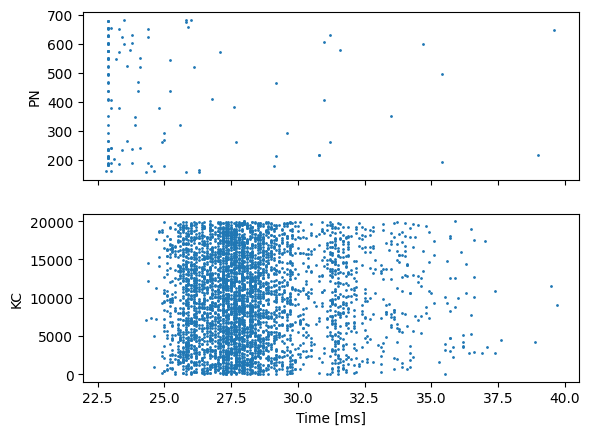

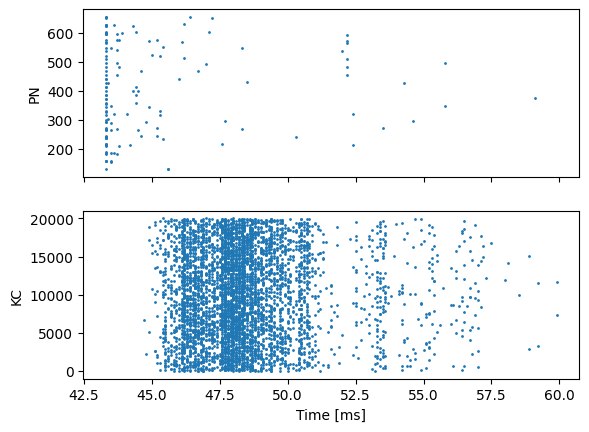

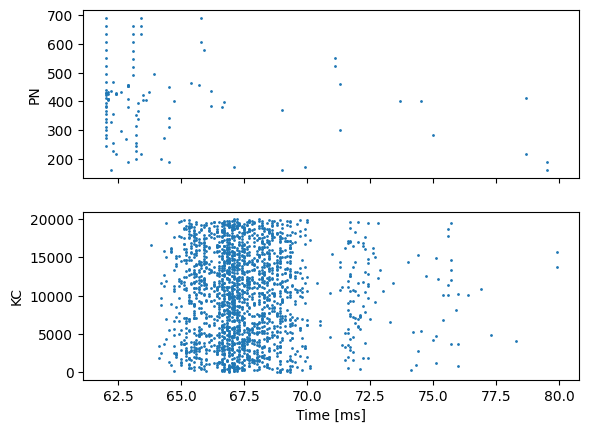

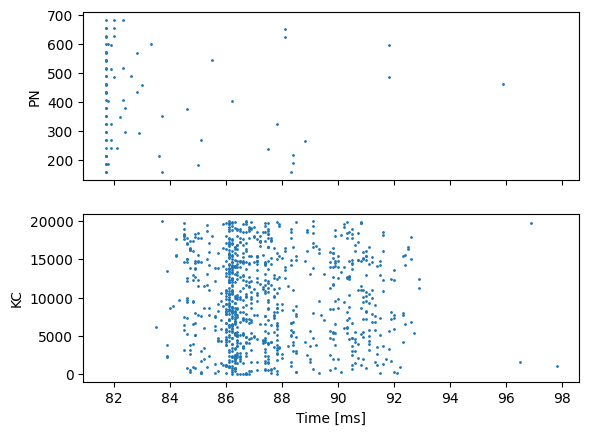

In [16]:
def reset_neuron(pop, var_init):
    # Reset variables
    for var_name, var_val in var_init.items():
        pop.vars[var_name].view[:] = var_val

        # Push the new values to GPU
        pop.vars[var_name].push_to_device()

for s in range(4):
    # Set training image
    pn_input.vars["magnitude"].view[:] = training_images[s] * INPUT_SCALE
    pn_input.vars["magnitude"].push_to_device()

    # Simulate present timesteps
    for i in range(present_timesteps):
        model.step_time()

    # Reset neuron state for next stimuli
    reset_neuron(pn, lif_init)
    reset_neuron(kc, lif_init)

    # Reset synapse state
    reset_out_post(pn_kc)

    # Download spikes from GPU
    model.pull_recording_buffers_from_device()

    # Plot PN and KC spikes
    fig, axes = plt.subplots(2, sharex=True)
    pn_spike_times, pn_spike_ids = pn.spike_recording_data[0]
    kc_spike_times, kc_spike_ids = kc.spike_recording_data[0]
    print(f"{len(np.unique(kc_spike_ids))} KC active")
    axes[0].scatter(pn_spike_times, pn_spike_ids, s=1)
    axes[0].set_ylabel("PN")
    axes[1].scatter(kc_spike_times, kc_spike_ids, s=1)
    axes[1].set_xlabel("Time [ms]")
    axes[1].set_ylabel("KC")
plt.show()

Oh dear! Even with normalised inputs and controlling for the initial state of the model before presenting each stimuli, we get very variable numbers of active Kenyon Cells.